<a href="https://colab.research.google.com/github/etoileboots/tbilisi_biking/blob/main/Jiao_recreation_houston_transit_desert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recreation of Jiao Methodology on Updated Census Data

In [1]:
!pip install census us osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 23.8 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.0.1
    Uninstalling geopandas-1.0.1:
      Successfully uninstalled geopandas-1.0.1


In [2]:
# import relevant libraries
import pandas as pd
import geopandas as gpd
import numpy as np
from census import Census
from us import states
import matplotlib.pyplot as plt
import osmnx as ox
import requests
from scipy.stats import zscore
from matplotlib.colors import TwoSlopeNorm
from shapely.geometry import LineString

## Data Pre-Processing (loading, merging, cleaning)

In [3]:
# load BG and tract shape files
BG_shp = gpd.read_file('/content/drive/MyDrive/capstone/data/jiao_recreation/tl_2020_48201_bg20 2/tl_2020_48201_bg20.shp')
tract_shp = gpd.read_file('/content/drive/MyDrive/capstone/data/jiao_recreation/tl_2020_48201_tract20/tl_2020_48201_tract20.shp')

In [4]:
# Reproject CRS
BG_shp = BG_shp.to_crs(epsg=3857)

# Rename and convert only the specified column to string
BG_shp = BG_shp.rename(columns={"GEOID20": "GEOID_BG"})
BG_shp["GEOID_BG"] = BG_shp["GEOID_BG"].astype(str)

BG_shp.head()  # Display the first few rows to verify the renaming and type change

STATEFP20 COUNTYFP20 TRACTCE20 BLKGRPCE20      GEOID_BG     NAMELSAD20  \
0        48        201    100001          1  482011000011  Block Group 1   
1        48        201    100001          2  482011000012  Block Group 2   
2        48        201    210400          1  482012104001  Block Group 1   
3        48        201    210400          2  482012104002  Block Group 2   
4        48        201    210500          1  482012105001  Block Group 1   

  MTFCC20 FUNCSTAT20  ALAND20  AWATER20   INTPTLAT20    INTPTLON20  \
0   G5030          S  1487729         0  +29.7522286  -095.3666708   
1   G5030          S  1062631     28976  +29.7590264  -095.3562888   
2   G5030          S  1236805         0  +29.7893615  -095.3666295   
3   G5030          S   575150         0  +29.7863478  -095.3609490   
4   G5030          S   598129         0  +29.7972828  -095.3621874   

                                            geometry  
0  POLYGON ((-10617052.129 3472431.021, -10617048...  
1  POLYGON ((-10615745.461 3472471.029, -10615679...  
2  POLYGON ((-10616753.793 3476682.632, -10616745...  
3  POLYGON ((-10616104.355 3476145.957, -10616093...  
4  POLYGON ((-10616310.185 3477634.824, -10616309...

In [5]:
tract_shp = tract_shp.to_crs(epsg=3857) # Reproject CRS
tract_shp = tract_shp.rename(columns={"GEOID20": "GEOID_TRACT"}) # rename the geoid to clarify it is geoid for census tract
tract_shp["GEOID_TRACT"] = tract_shp["GEOID_TRACT"].astype(str)
tract_shp.head() # show dataframe for tracts

STATEFP20 COUNTYFP20 TRACTCE20  GEOID_TRACT   NAME20    NAMELSAD20 MTFCC20  \
0        48        201    100001  48201100001  1000.01  Census Tract   G5020   
1        48        201    210400  48201210400     2104  Census Tract   G5020   
2        48        201    210500  48201210500     2105  Census Tract   G5020   
3        48        201    210600  48201210600     2106  Census Tract   G5020   
4        48        201    210700  48201210700     2107  Census Tract   G5020   

  FUNCSTAT20  ALAND20  AWATER20   INTPTLAT20    INTPTLON20  \
0          S  2550360     28976  +29.7547559  -095.3621919   
1          S  1811955         0  +29.7864417  -095.3621992   
2          S  2154322         0  +29.7952549  -095.3603917   
3          S  2333778         0  +29.8070404  -095.3653598   
4          S  1133524         0  +29.8067305  -095.3535208   

                                            geometry  
0  POLYGON ((-10617052.129 3472431.021, -10617048...  
1  POLYGON ((-10616753.793 3476682.632, -10616745...  
2  POLYGON ((-10616755.574 3477872.658, -10616738...  
3  POLYGON ((-10617111.351 3479560.845, -10617099...  
4  POLYGON ((-10615157.694 3479623.455, -10615157...

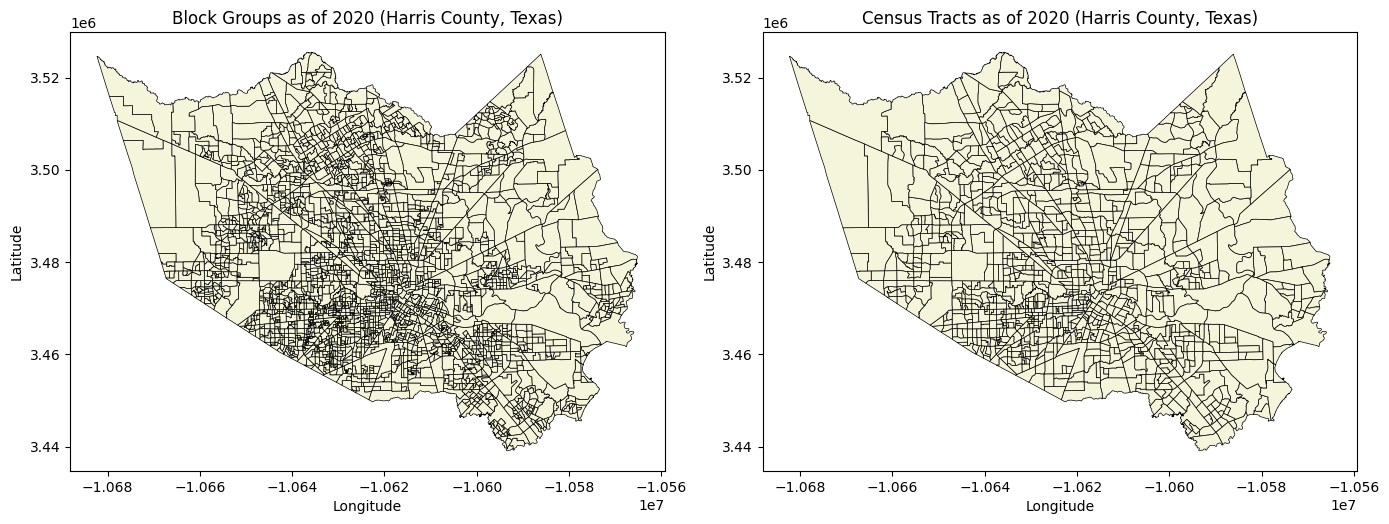

In [6]:
# Plot the Block Group and Census Tract Data
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot Block Groups
BG_shp.plot(color='beige', edgecolor='k', linewidth=0.5, ax=axes[0])
axes[0].set_title("Block Groups as of 2020 (Harris County, Texas)")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")

# Plot Census Tracts
tract_shp.plot(color='beige', edgecolor='k', linewidth=0.5, ax=axes[1])
axes[1].set_title("Census Tracts as of 2020 (Harris County, Texas)")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
plt.tight_layout()
plt.show()

## Use Census API to Extract American Community Survey Data

In [7]:
# Unique api key
api_key = '506f36e1bf9d0819b1136cffc88be5ad1c51074f'
c = Census(api_key)

In [8]:
def fetch_acs_data(variables, geo_level, geo_filter, year=2020, state=48, county=201):
    """
    Fetch ACS data for a specific geographic level.

    Parameters:
    - variables (dict): Dictionary of ACS variables and their descriptions.
    - geo_level (str): The geographic level, e.g., 'block group:*' or 'tract:*'.
    - geo_filter (str): A string defining geographic filter in the API call.
    - year (int): The year of the ACS data (default is 2020).
    - state (int): State FIPS code (default is 48 for Texas).
    - county (int): County FIPS code (default is 201 for Harris County).

    Returns:
    - DataFrame: A DataFrame with fetched data.
    """
    try:
        data = c.acs5.get(list(variables.keys()), geo={'for': geo_level, 'in': geo_filter}, year=year)
        df = pd.DataFrame(data).rename(columns=variables)
        return df
    except Exception as e:
        print(f"Error fetching ACS data for {geo_level}: {e}")
        return pd.DataFrame()

def get_acs_data():
    # Block group level variables
    acs_bg_vars = {
        'B01001_001E': 'total_pop',
        'B01001_003E': 'm_under_5', 'B01001_004E': 'm_5_to_9', 'B01001_005E': 'm_10_to_14',
        'B01001_006E': 'm_15_to_17', 'B01001_027E': 'f_under_5', 'B01001_028E': 'f_5_to_9',
        'B01001_029E': 'f_10_to_14', 'B01001_030E': 'f_15_to_17'
    }
    # Census tract level variables
    acs_tract_vars = {
        'B08201_001E': 'total_households', 'B08201_002E': 'no_veh_households',
        'B08201_003E': 'one_veh_households', 'B08201_004E': 'two_veh_households',
        'B08201_005E': 'three_veh_households', 'B08201_006E': 'four_plus_veh_households',
        'B26001_001E': 'GQ_pop'
    }

    # Fetch block group and tract data
    acs_bg_df = fetch_acs_data(acs_bg_vars, 'block group:*', f'state:{48} county:{201}')
    acs_tract_df = fetch_acs_data(acs_tract_vars, 'tract:*', f'state:{48} county:{201}')

    # Ensure IDs are formatted for merging
    acs_bg_df['GEOID_BG'] = (acs_bg_df['state'] + acs_bg_df['county'] + acs_bg_df['tract'] + acs_bg_df['block group']).astype(str)
    acs_tract_df['GEOID_TRACT'] = (acs_tract_df['state'] + acs_tract_df['county'] + acs_tract_df['tract']).astype(str)

    # Block group derived columns
    acs_bg_df.eval(
        """
        pop_over_17 = total_pop - (m_5_to_9 + m_10_to_14 + m_15_to_17 + f_5_to_9 + f_10_to_14 + f_15_to_17)
        pop_10_to_17 = (m_10_to_14 / 2) + m_15_to_17 + (f_10_to_14 / 2) + f_15_to_17
        """,
        inplace=True
    )

    # Tract level: calculate total vehicles
    acs_tract_df.eval(
        """
        total_tract_veh = (one_veh_households * 1) + (two_veh_households * 2) +(three_veh_households * 3) + (four_plus_veh_households * 4)
        """,
        inplace=True
    )

    return acs_bg_df, acs_tract_df

# Usage
acs_bg_df, acs_tract_df = get_acs_data()


In [9]:
# Uncomment to see data structure
#print(acs_bg_df.head())
#print(acs_tract_df.head())

In [10]:
# Merge all data together and make estimates proportional

def merge_tracts_and_blocks_with_acs(tract_shp, BG_shp, acs_bg_df, acs_tract_df):
    """
    Merge ACS data at both block group and tract levels onto a block group shapefile with tract info.
    """

    # Create tract-level GEOID for block group DataFrame
    BG_shp['GEOID_TRACT'] = BG_shp['GEOID_BG'].str[:11]

    # Calculate proportional area of each block group relative to its tract
    tract_shp['tract_area'] = tract_shp.geometry.area
    BG_shp['bg_area'] = BG_shp.geometry.area
    merged_shp = BG_shp.merge(tract_shp[['GEOID_TRACT', 'tract_area']], on="GEOID_TRACT", how='left')
    merged_shp['proportional_area'] = merged_shp['bg_area'] / merged_shp['tract_area']

    # Merge tract-level ACS data onto block groups using tract GEOID
    shp_with_tract_acs = merged_shp.merge(acs_tract_df, on='GEOID_TRACT', how='left', suffixes=('', '_tract'))

    # Calculate area-proportioned estimates for tract variables in each block group
    for col in ['total_households', 'no_veh_households', 'one_veh_households', 'two_veh_households', 'three_veh_households', 'four_plus_veh_households', 'total_tract_veh', 'GQ_pop']:
        shp_with_tract_acs[f'{col}_scaled'] = shp_with_tract_acs[col] * shp_with_tract_acs['proportional_area']

    # Merge block group-level ACS data directly onto BG_with_tract_acs
    shp_with_all_acs = shp_with_tract_acs.merge(acs_bg_df, on="GEOID_BG", how='left', suffixes=('', '_bg'))

    return shp_with_all_acs

In [11]:
# merge tract, block group, and acs data together
pd.set_option('display.max_columns', None)
merged_df = merge_tracts_and_blocks_with_acs(tract_shp, BG_shp, acs_bg_df, acs_tract_df)

In [12]:
merged_df.head()

STATEFP20 COUNTYFP20 TRACTCE20 BLKGRPCE20      GEOID_BG     NAMELSAD20  \
0        48        201    100001          1  482011000011  Block Group 1   
1        48        201    100001          2  482011000012  Block Group 2   
2        48        201    210400          1  482012104001  Block Group 1   
3        48        201    210400          2  482012104002  Block Group 2   
4        48        201    210500          1  482012105001  Block Group 1   

  MTFCC20 FUNCSTAT20  ALAND20  AWATER20   INTPTLAT20    INTPTLON20  \
0   G5030          S  1487729         0  +29.7522286  -095.3666708   
1   G5030          S  1062631     28976  +29.7590264  -095.3562888   
2   G5030          S  1236805         0  +29.7893615  -095.3666295   
3   G5030          S   575150         0  +29.7863478  -095.3609490   
4   G5030          S   598129         0  +29.7972828  -095.3621874   

                                            geometry  GEOID_TRACT  \
0  POLYGON ((-10617052.129 3472431.021, -10617048...  48201100001   
1  POLYGON ((-10615745.461 3472471.029, -10615679...  48201100001   
2  POLYGON ((-10616753.793 3476682.632, -10616745...  48201210400   
3  POLYGON ((-10616104.355 3476145.957, -10616093...  48201210400   
4  POLYGON ((-10616310.185 3477634.824, -10616309...  48201210500   

        bg_area    tract_area  proportional_area  total_households  \
0  1.980565e+06  3.433971e+06           0.576757            2560.0   
1  1.453405e+06  3.433971e+06           0.423243            2560.0   
2  1.647630e+06  2.413826e+06           0.682580            1548.0   
3  7.661955e+05  2.413826e+06           0.317420            1548.0   
4  7.969803e+05  2.870424e+06           0.277653            1774.0   

   no_veh_households  one_veh_households  two_veh_households  \
0              516.0              1288.0               711.0   
1              516.0              1288.0               711.0   
2              326.0               527.0               444.0   
3              326.0               527.0               444.0   
4              405.0               613.0               335.0   

   three_veh_households  four_plus_veh_households  GQ_pop state county  \
0                  45.0                       0.0  1381.0    48    201   
1                  45.0                       0.0  1381.0    48    201   
2                 232.0                      19.0   139.0    48    201   
3                 232.0                      19.0   139.0    48    201   
4                 357.0                      64.0    65.0    48    201   

    tract  total_tract_veh  total_households_scaled  no_veh_households_scaled  \
0  100001           2845.0              1476.497069                297.606440   
1  100001           2845.0              1083.502931                218.393560   
2  210400           2187.0              1056.634484                222.521216   
3  210400           2187.0               491.365516                103.478784   
4  210500           2610.0               492.555555                112.449267   

   one_veh_households_scaled  two_veh_households_scaled  \
0                 742.862588                 410.073991   
1                 545.137412                 300.926009   
2                 359.719879                 303.065705   
3                 167.280121                 140.934295   
4                 170.200989                  93.013591   

   three_veh_households_scaled  four_plus_veh_households_scaled  \
0                    25.954050                         0.000000   
1                    19.045950                         0.000000   
2                   158.358657                        12.969028   
3                    73.641343                         6.030972   
4                    99.121946                        17.769761   

   total_tract_veh_scaled  GQ_pop_scaled  total_pop  m_under_5  m_5_to_9  \
0             1640.872719     796.500958     2451.0        0.0       0.0   
1             1204.127281     584.499042     2639.0       18.

In [18]:
# Summary statistics for specific columns
merged_df[['GEOID_BG', 'total_tract_veh', 'total_pop']].describe()


total_tract_veh     total_pop
count      2830.000000   2830.000000
mean       2881.710954   1653.925442
std        1430.939225    908.436655
min           0.000000      0.000000
25%        1908.000000   1041.250000
50%        2637.000000   1492.500000
75%        3645.500000   2065.000000
max       12610.000000  12769.000000

## Jiao Calculations

In [53]:

def plot_heatmap_on_bg(block_group_shapes, column_name, title):
    """
    Plot heatmap onto the block groups
    """
    fig, ax = plt.subplots(figsize=(10, 10))

        # Center the colormap around zero
    vmin = block_group_shapes[column_name].min()
    vmax = block_group_shapes[column_name].max()
    vcenter = 0  # Center at zero for z-scores
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    block_group_shapes.plot(column=column_name, cmap='RdBu_r', linewidth=0.8, ax=ax,
                           edgecolor="black", legend=True, norm=norm,
                           legend_kwds={'orientation': 'horizontal', 'shrink': 0.5,
                                        'pad': 0.05, 'aspect': 50})  # Adjust legend properties

    plt.title(title)
    plt.tight_layout() # Adjust layout to prevent overlapping
    plt.show()


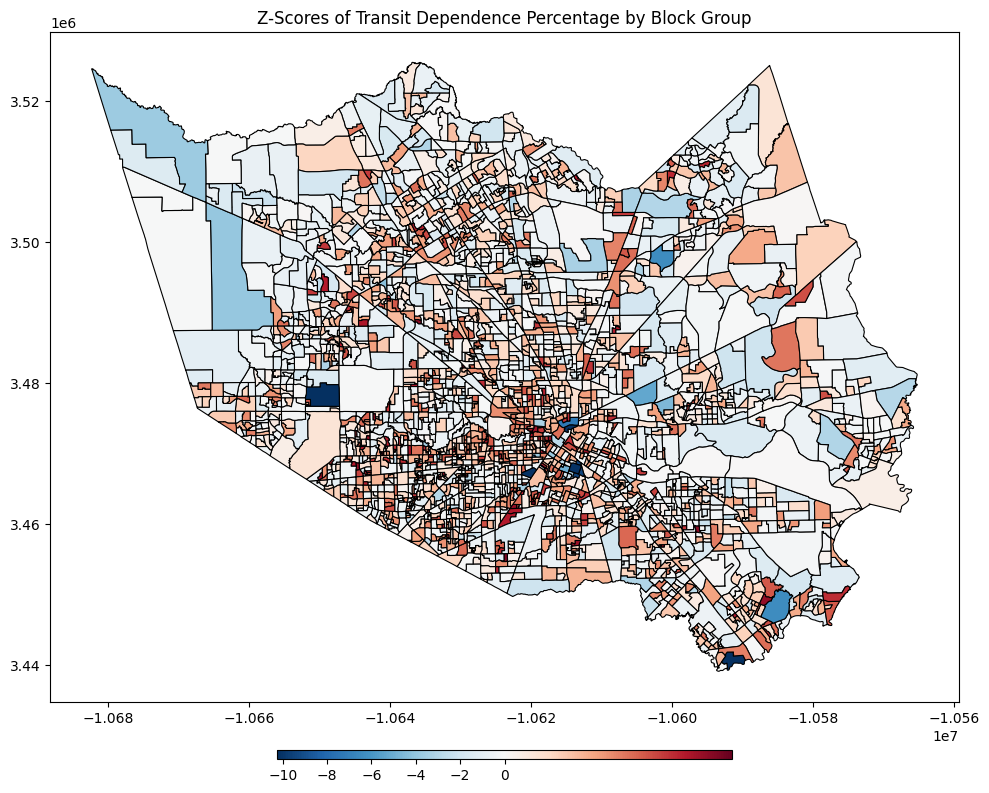

In [95]:
import numpy as np
nat_carpool_ratio = 0.09
def est_transit_need(merged_df, show_visual = True):
    merged_df['household_drivers'] = merged_df['pop_over_17'] - merged_df['GQ_pop_scaled'] # adjusted from calculation: household_drivers = pop_over_16 - gq_population
    merged_df['trans_dep_household_pop'] = np.maximum(0, (merged_df['household_drivers'] - merged_df['total_tract_veh_scaled']*nat_carpool_ratio))
    merged_df['trans_dep_per'] = (merged_df['trans_dep_household_pop'] + merged_df['pop_10_to_17'])/merged_df['total_pop'] # adjusted not to include + (non-institutionalized population living in group quarters) since this variable is unavailable on tract/block group level
    merged_df['trans_dep_per'] = merged_df['trans_dep_per'].fillna(merged_df['trans_dep_per'].mean())
    merged_df['trans_dep_per_z'] = zscore(merged_df['trans_dep_per'])
    if show_visual==True:
        plot_heatmap_on_bg(merged_df, 'trans_dep_per_z', "Z-Scores of Transit Dependence Percentage by Block Group")

    return merged_df[["GEOID_BG", "trans_dep_per_z", "geometry"]]

transit_need = est_transit_need(merged_df)

In [34]:
def calculate_stops_density(block_group_shapes, show_visual=True):
    """
    Calculate transit stop density within block groups
    """
    stops = pd.read_csv(f"{gtfs_data_path}/stops.txt") # Load relevant data
    stops_gdf = gpd.GeoDataFrame( # Convert stops.txt to GeoDataFrame
        stops,
        geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)
    stops_in_groups = gpd.sjoin(stops_gdf, block_group_shapes, how="inner", predicate="intersects") # Spatial join to assign stops to block groups
    stop_density = stops_in_groups.groupby('GEOID20').size() / block_group_shapes.set_index('GEOID20')['acres'] # Calculate stops density per block group
    block_group_shapes['stops_density'] = block_group_shapes['GEOID20'].map(stop_density).fillna(0) # Map stop density values to block groups and visualize
    block_group_shapes['stops_density_z'] = zscore(block_group_shapes['stops_density'])
    if show_visual == True:
        plot_heatmap_on_bg(block_group_shapes, 'stops_density_z', "Stop Density by Block Group")

    return block_group_shapes['GEOID20'], block_group_shapes['stops_density_z']

In [35]:
def frequency_weekday_service(block_group_shapes, show_visual=True):
    """
    Calculate the density of frequency of weekday service
    """
    routes = pd.read_csv(f"{gtfs_data_path}/routes.txt") # Load relevant data
    routes_gdf = gpd.GeoDataFrame(
        routes,
        crs="EPSG:4326"
    ).to_crs(espg=3857)
    route_block_group_join = gpd.sjoin(routes_gdf, block_group_shapes, how="inner", predicate="intersects") # Spatial join to assign routes to block groups

    # Sum the weekday route frequencies for each block group
    block_group_frequencies = route_block_group_join.groupby('GEOID20')['frequency'].sum()

    # Merge frequency data back into the block group shapes GeoDataFrame
    # Ensure 'GEOID20' is set as the index before merging
    #block_group_shapes = block_group_shapes.set_index('GEOID20')
    block_group_shapes['total_weekday_frequency'] = block_group_frequencies

    # Fill NaN values with 0 for block groups with no intersecting routes
    block_group_shapes['total_weekday_frequency'] = block_group_shapes['total_weekday_frequency'].fillna(0)

    # Plot the block groups with a heatmap based on total weekday route frequency
    fig, ax = plt.subplots(figsize=(12, 12))
    block_group_shapes.plot(
        column='total_weekday_frequency',
        cmap='YlOrRd',  # Choose a color map with good contrast for frequency heatmap
        linewidth=0.8,
        edgecolor='black',
        legend=True,
        legend_kwds={'label': "Total Weekday Route Frequency", 'orientation': "horizontal"},
        ax=ax
    )

    # Customize plot
    plt.title("Transit Route Weekday Frequency Heatmap by Block Group")
    plt.show()


In [36]:

def calculate_avg_weekday_service_per_block_group(gtfs_data_path, block_group_shapes, show_visual=True):
    # Load GTFS data
    calendar = pd.read_csv(f"{gtfs_data_path}/calendar.txt")
    trips = pd.read_csv(f"{gtfs_data_path}/trips.txt")
    stop_times = pd.read_csv(f"{gtfs_data_path}/stop_times.txt")
    shapes = pd.read_csv(f"{gtfs_data_path}/shapes.txt")

    # Filter services that operate on weekdays and count active weekdays
    weekday_services = calendar[(calendar[['monday', 'tuesday', 'wednesday', 'thursday', 'friday']].sum(axis=1) > 0)]
    weekday_services['weekday_count'] = weekday_services[['monday', 'tuesday', 'wednesday', 'thursday', 'friday']].sum(axis=1)

    # Filter trips to weekday services and count trips per route, divided by active days
    weekday_trips = trips[trips['service_id'].isin(weekday_services['service_id'])]
    stop_times_weekday = stop_times.merge(weekday_trips[['trip_id', 'route_id', 'service_id']], on='trip_id')
    weekday_counts = weekday_services.set_index('service_id')['weekday_count']
    stop_times_weekday['average_weekday_frequency'] = stop_times_weekday['service_id'].map(weekday_counts)

    # Calculate average weekday frequency per route
    avg_freq_per_route = (stop_times_weekday.groupby('route_id').size() /
                          stop_times_weekday.groupby('route_id')['average_weekday_frequency'].first())

    # Convert shapes to line geometries, associate with route frequency
    route_shapes = (shapes.sort_values(['shape_id', 'shape_pt_sequence'])
                    .groupby('shape_id').apply(lambda x: LineString(zip(x.shape_pt_lon, x.shape_pt_lat))))
    routes_gdf = gpd.GeoDataFrame(route_shapes, columns=['geometry'], crs="EPSG:4326").to_crs(epsg=3857).reset_index()
    routes_gdf = routes_gdf.merge(weekday_trips[['route_id', 'shape_id']].drop_duplicates()
                                  .assign(avg_freq=avg_freq_per_route), on='shape_id', how='left')

    # Spatial join with block groups to calculate average frequency per block group
    block_group_freqs = (gpd.sjoin(routes_gdf, block_group_shapes, how="inner", predicate="intersects")
                         .groupby('GEOID20')['avg_freq'].sum())

    # Map frequencies back to block groups and fill missing values with 0
    block_group_shapes['average_weekday_service'] = block_group_shapes['GEOID20'].map(block_group_freqs).fillna(0)
    freq_density = block_group_freqs.groupby('GEOID20').size() / block_group_shapes.set_index('GEOID20')['acres'] # Calculate stops density per block group
    block_group_shapes['average_weekday_service_density'] = block_group_shapes['GEOID20'].map(freq_density).fillna(0) # Map stop density values to block groups and visualize
    block_group_shapes['average_weekday_service_density_z'] = zscore(block_group_shapes['average_weekday_service_density'])
    block_group_shapes = block_group_shapes.reset_index()
    if show_visual == True:
        plot_heatmap_on_bg(block_group_shapes, 'average_weekday_service_density_z', "Z-scores of Average Weekday Service Density by Block Group")

    # Return GeoDataFrame with results
    return block_group_shapes[['GEOID20', 'average_weekday_service_density_z']]




In [37]:

def calculate_stops_density(block_group_shapes, show_visual=True):
    """
    Calculate transit stop density within block groups
    """
    stops = pd.read_csv(f"{gtfs_data_path}/stops.txt") # Load relevant data
    stops_gdf = gpd.GeoDataFrame( # Convert stops.txt to GeoDataFrame
        stops,
        geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)
    stops_in_groups = gpd.sjoin(stops_gdf, block_group_shapes, how="inner", predicate="intersects") # Spatial join to assign stops to block groups
    stop_density = stops_in_groups.groupby('GEOID20').size() / block_group_shapes.set_index('GEOID20')['acres'] # Calculate stops density per block group
    block_group_shapes['stops_density'] = block_group_shapes['GEOID20'].map(stop_density).fillna(0) # Map stop density values to block groups and visualize
    block_group_shapes['stops_density_z'] = zscore(block_group_shapes['stops_density'])
    if show_visual == True:
        plot_heatmap_on_bg(block_group_shapes, 'stops_density_z', "Z-Scores of Stop Density by Block Group")
    block_group_shapes = block_group_shapes.reset_index()
    return block_group_shapes[['GEOID20', 'stops_density_z']]

In [38]:

def calculate_route_density(gtfs_data_path, block_group_shapes, show_visual=True):
    """
    Calculates the density of unique transit routes within each block group.

    Args:
        gtfs_data_path (str): Path to the GTFS data directory.
        block_group_shapes (geopandas.GeoDataFrame): GeoDataFrame containing block group shapes.

    Returns:
        geopandas.GeoDataFrame: Block group shapes with an added 'route_density' column.
    """

    # Load required GTFS files
    trips = pd.read_csv(f"{gtfs_data_path}/trips.txt")
    stop_times = pd.read_csv(f"{gtfs_data_path}/stop_times.txt")
    stops = pd.read_csv(f"{gtfs_data_path}/stops.txt")

    # Convert stops to GeoDataFrame
    stops_gdf = gpd.GeoDataFrame(
        stops,
        geometry=gpd.points_from_xy(stops.stop_lon, stops.stop_lat),
        crs="EPSG:4326"
    ).to_crs(block_group_shapes.crs)  # Use the same CRS as block groups

    # Spatial join to assign stops to block groups
    stops_in_groups = gpd.sjoin(stops_gdf, block_group_shapes, how="inner", predicate="intersects")

    # Merge with trips and stop_times to get route information
    trips_in_groups = stops_in_groups.merge(stop_times[['stop_id', 'trip_id']], on='stop_id')
    route_density_df = trips_in_groups.merge(trips[['trip_id', 'route_id']], on='trip_id')

    # Calculate route density per block group (unique routes per area)
    route_density = route_density_df.groupby('GEOID20')['route_id'].nunique()
    route_density_acre = route_density / block_group_shapes.set_index('GEOID20')['acres']
    block_group_shapes['route_density'] = block_group_shapes['GEOID20'].map(route_density_acre).fillna(0) # Map stop density values to block groups and visualize
    block_group_shapes['route_density_z'] = zscore(block_group_shapes['route_density'])
    block_group_shapes = block_group_shapes.reset_index()
    if show_visual == True:
        plot_heatmap_on_bg(block_group_shapes, 'route_density_z', "Z-Scores of Route Density by Block Group")
    return block_group_shapes[['GEOID20','route_density_z']]

In [82]:
import geopandas as gpd
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

def load_street_network(place_name="Houston, Texas, USA", crs_epsg=3857):
    print(f"Downloading street network data for {place_name}...")
    graph = ox.graph_from_place(place_name, network_type='all')
    edges = ox.utils_graph.graph_to_gdfs(graph, nodes=False, edges=True)
    nodes = ox.utils_graph.graph_to_gdfs(graph, nodes=True, edges=False)

    edges = edges.to_crs(epsg=crs_epsg)
    nodes = nodes.to_crs(epsg=crs_epsg)

    return edges, nodes

def calculate_transit_features_per_block_group(block_group_shapes, edges, nodes, show_visual=True):
    # Reproject block group shapes and calculate area in acres
    block_group_shapes = block_group_shapes.to_crs(epsg=3857)
    block_group_shapes['acres'] = block_group_shapes.geometry.area * 0.000247105
    block_group_shapes['GEOID_BG'] = block_group_shapes['GEOID20']
    print("Acreage per block group:\n", block_group_shapes['acres'].describe())

    # Filter edges for each feature type
    sidewalks = edges[edges['highway'] == 'footway']
    bike_routes = edges[edges['cycleway'].notna() | (edges['highway'] == 'cycleway')] \
        if 'cycleway' in edges.columns else edges[edges['highway'].isin(['cycleway', 'path', 'track'])]
    low_speed_roads = edges[edges['highway'].isin(['residential', 'living_street'])]

    # Clip each feature type to block group boundaries and calculate lengths
    sidewalks_clipped = gpd.overlay(sidewalks, block_group_shapes, how='intersection', keep_geom_type=False)
    sidewalks_clipped['length'] = sidewalks_clipped.geometry.length

    bike_routes_clipped = gpd.overlay(bike_routes, block_group_shapes, how='intersection', keep_geom_type=False)
    bike_routes_clipped['length'] = bike_routes_clipped.geometry.length

    low_speed_roads_clipped = gpd.overlay(low_speed_roads, block_group_shapes, how='intersection', keep_geom_type=False)
    low_speed_roads_clipped['length'] = low_speed_roads_clipped.geometry.length

    # Summing lengths per block group
    sidewalk_length_per_block_group = sidewalks_clipped.groupby('GEOID_BG')['length'].sum()
    bike_route_length_per_block_group = bike_routes_clipped.groupby('GEOID_BG')['length'].sum()
    low_speed_road_length_per_block_group = low_speed_roads_clipped.groupby('GEOID_BG')['length'].sum()

    # Calculate intersection density: nodes with street_count > 2
    intersections = nodes[nodes['street_count'] > 2]
    intersections_clipped = gpd.overlay(intersections, block_group_shapes, how='intersection', keep_geom_type=False)
    intersection_density_per_block_group = intersections_clipped.groupby('GEOID_BG').size() / block_group_shapes.set_index('GEOID_BG')['acres']

    # Map the results to the block group shapes GeoDataFrame
    block_group_shapes['sidewalk_length'] = block_group_shapes['GEOID_BG'].map(sidewalk_length_per_block_group).fillna(0)
    block_group_shapes['bike_route_length'] = block_group_shapes['GEOID_BG'].map(bike_route_length_per_block_group).fillna(0)
    block_group_shapes['low_speed_road_length'] = block_group_shapes['GEOID_BG'].map(low_speed_road_length_per_block_group).fillna(0)
    block_group_shapes['intersection_density'] = block_group_shapes['GEOID_BG'].map(intersection_density_per_block_group).fillna(0)

    # Calculate density and Z-score for each metric
    for feature in ['sidewalk_length', 'bike_route_length', 'low_speed_road_length', 'intersection_density']:
        density_col = f"{feature}_density"
        z_col = f"{feature}_density_z"
        block_group_shapes[density_col] = block_group_shapes[feature] / block_group_shapes['acres']
        print(f"{density_col} by block group:\n", block_group_shapes[density_col].describe())

        block_group_shapes[z_col] = zscore(block_group_shapes[density_col].fillna(0))
        print(f"{z_col} by block group:\n", block_group_shapes[z_col].describe())
    # Optionally visualize
    if show_visual:
        plot_heatmap_on_bg(block_group_shapes, 'sidewalk_length_density_z', "Z-Scores of Sidewalk Density by Block Group")
        plot_heatmap_on_bg(block_group_shapes, 'bike_route_length_density_z', "Z-Scores of Bike Route Density by Block Group")
        plot_heatmap_on_bg(block_group_shapes, 'low_speed_road_length_density_z', "Z-Scores of Low Speed Road Length Density by Block Group")
        plot_heatmap_on_bg(block_group_shapes, 'intersection_density_density_z', "Z-Scores of Intersection Density by Block Group")

    return block_group_shapes[[
        'GEOID20', 'sidewalk_length_density_z', 'bike_route_length_density_z',
        'low_speed_road_length_density_z', 'intersection_density_density_z'
    ]]

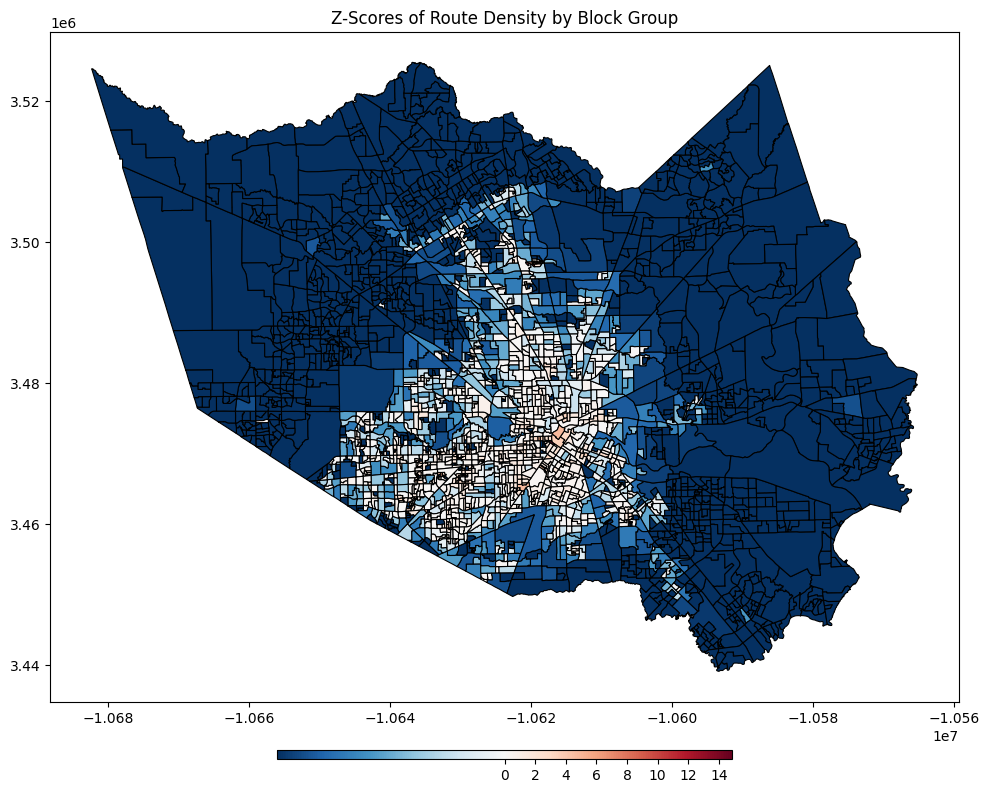

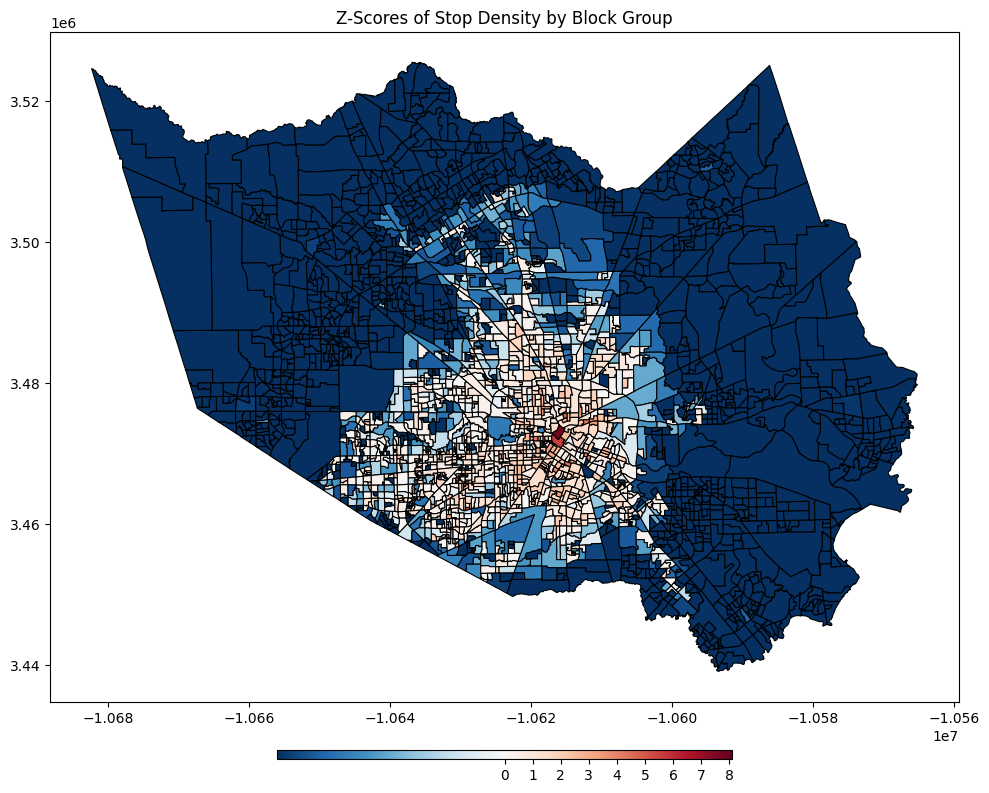

<ipython-input-36-0c5fc2dc99f6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekday_services['weekday_count'] = weekday_services[['monday', 'tuesday', 'wednesday', 'thursday', 'friday']].sum(axis=1)
<ipython-input-36-0c5fc2dc99f6>:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .groupby('shape_id').apply(lambda x: LineString(zip(x.shape_pt_lon, x.shape_pt_lat))))


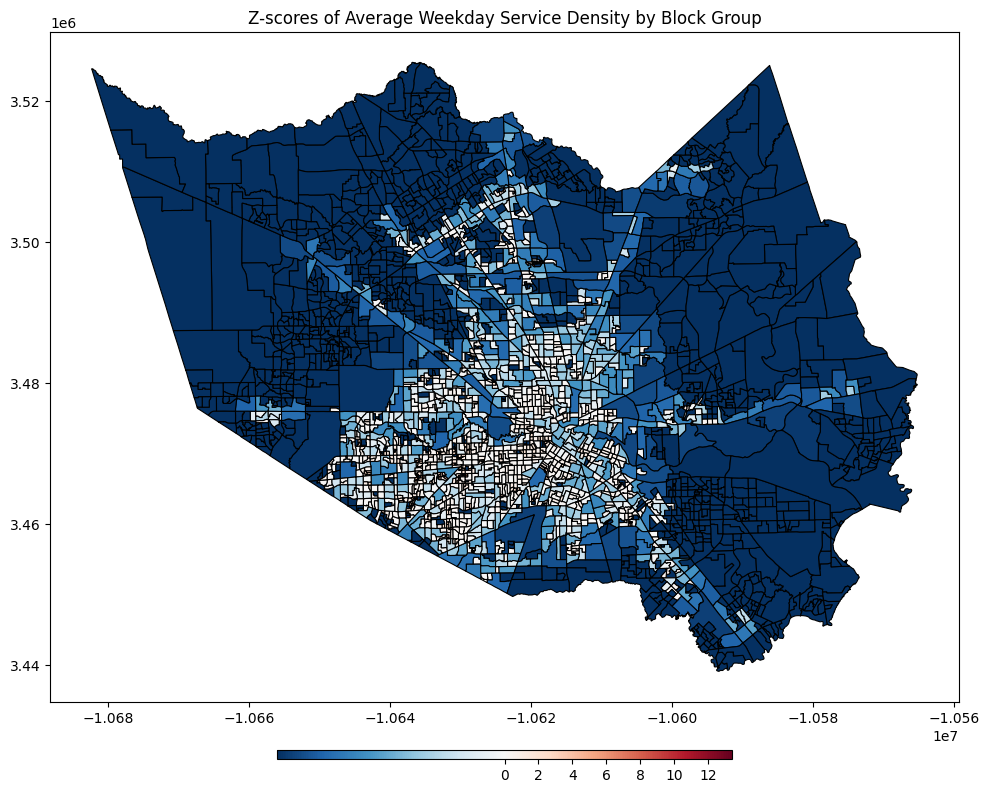

Acreage per block group:
 count     2830.000000
mean       536.228858
std       1470.094446
min          9.554892
25%        133.313092
50%        241.785948
75%        435.674189
max      36109.020921
Name: acres, dtype: float64
sidewalk_length_density by block group:
 count    2830.000000
mean        5.809353
std        18.309301
min         0.000000
25%         0.000000
50%         0.000000
75%         2.328837
max       254.576174
Name: sidewalk_length_density, dtype: float64
sidewalk_length_density_z by block group:
 count    2.830000e+03
mean    -1.004301e-17
std      1.000177e+00
min     -3.173458e-01
25%     -3.173458e-01
50%     -3.173458e-01
75%     -1.901291e-01
max      1.358931e+01
Name: sidewalk_length_density_z, dtype: float64
bike_route_length_density by block group:
 count    2830.000000
mean        1.486865
std         5.559564
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        58.994193
Name: bike_route_length_density, dtyp

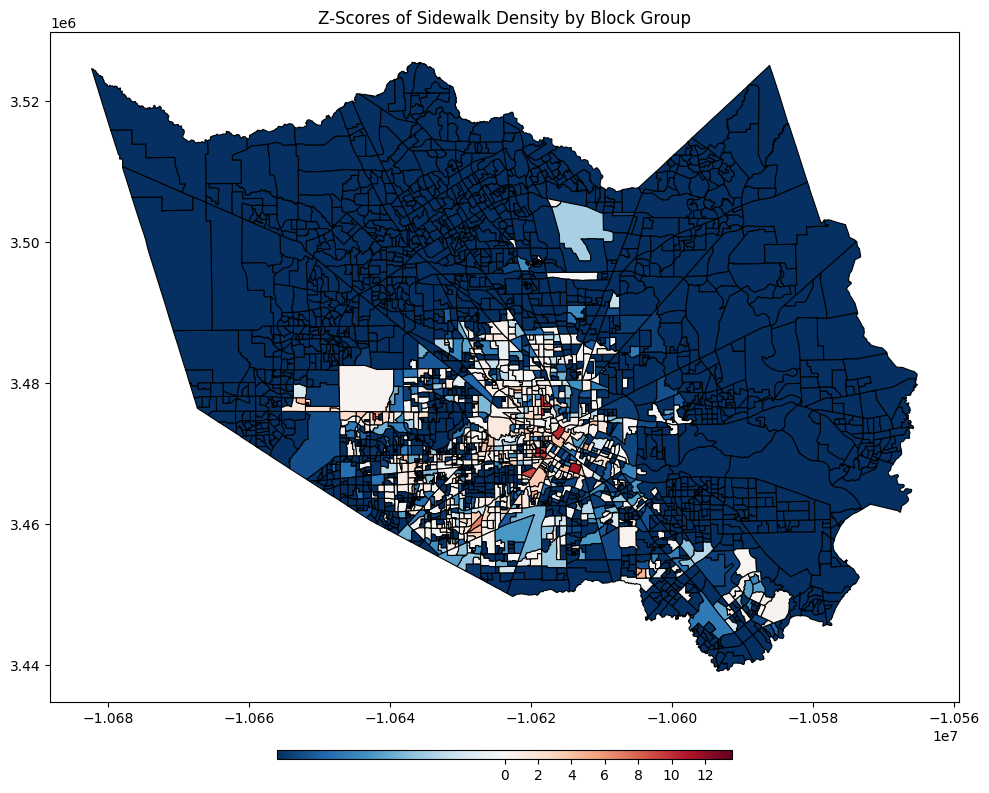

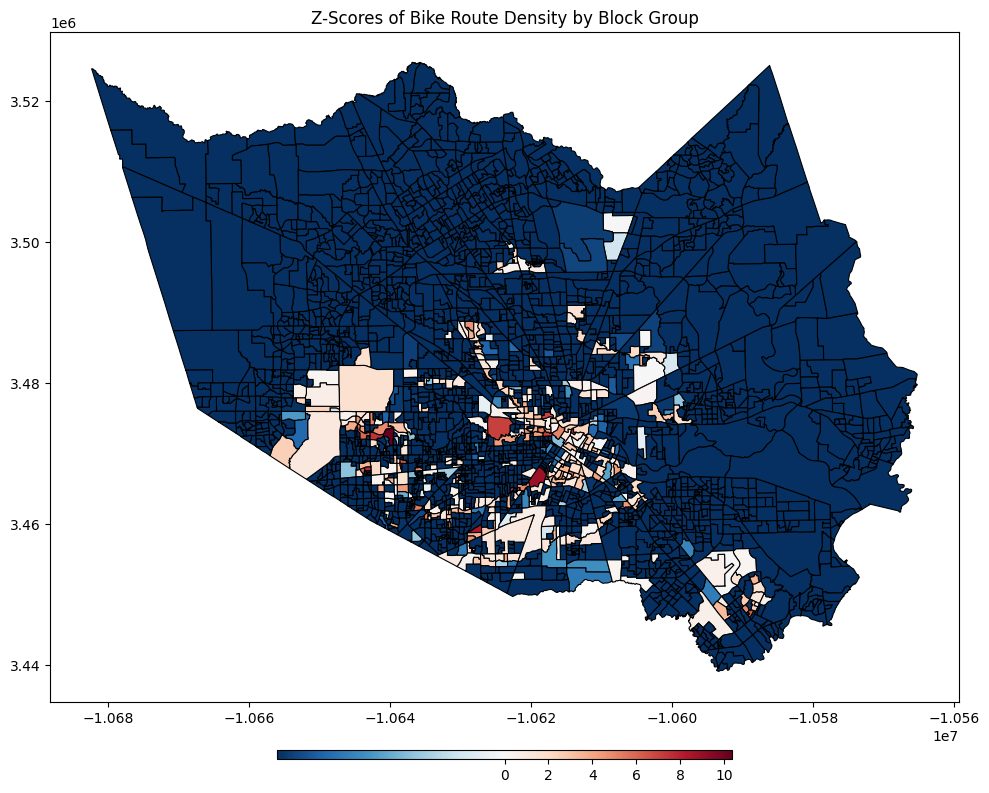

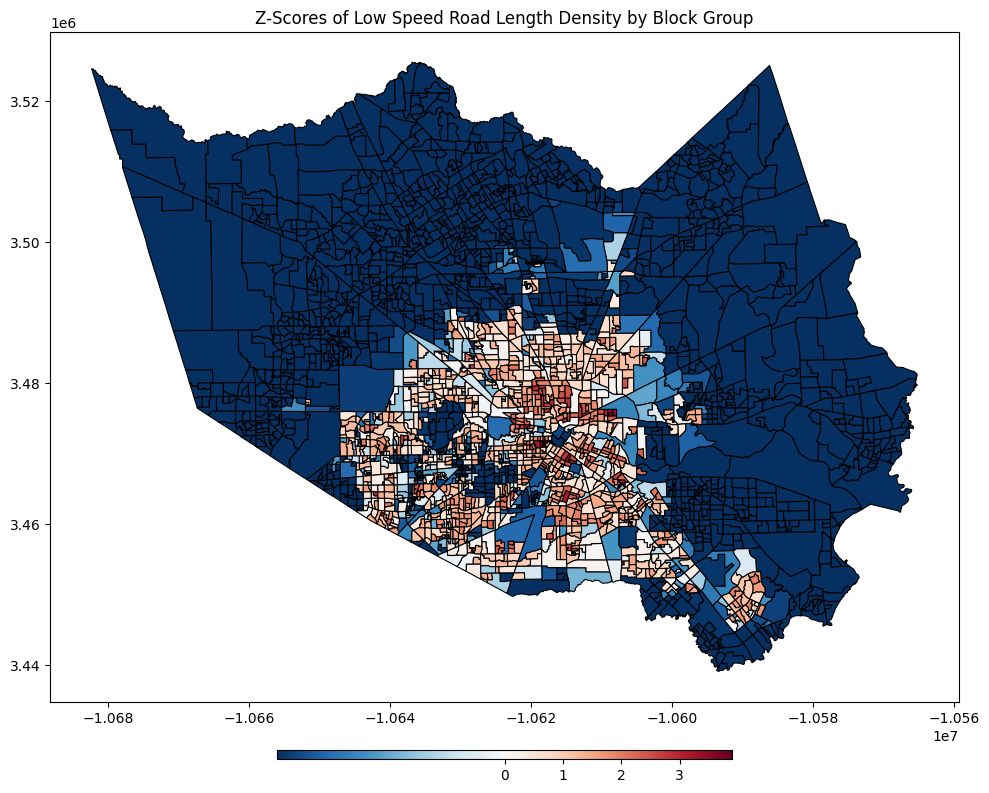

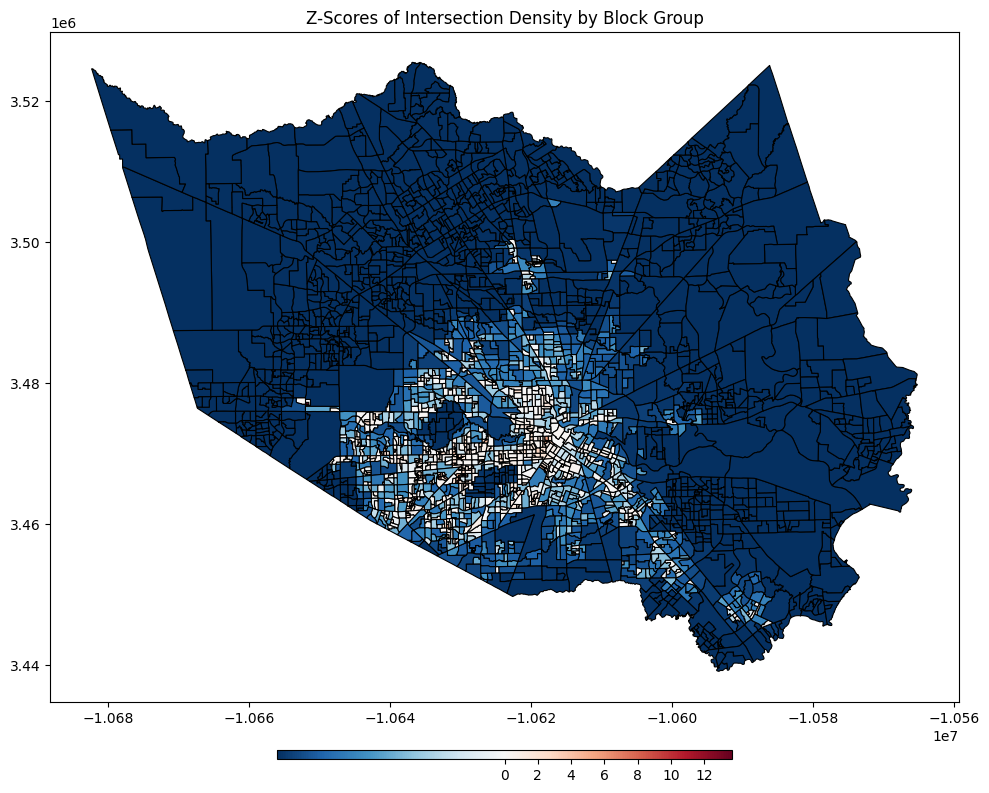

        GEOID20  stops_density_z  route_density_z  \
0  482011000011         5.601930         3.573185   
1  482011000012         2.624560         3.062493   
2  482012104001         0.518866         0.161228   
3  482012104002         1.477535         0.214426   
4  482012105001         0.768154         0.185047   

   average_weekday_service_density_z  sidewalk_length_density_z  \
0                          -0.297274                   3.636781   
1                          -0.198611                   3.003970   
2                          -0.242308                  -0.207977   
3                           0.133856                  -0.266098   
4                           0.106696                  -0.312301   

   bike_route_length_density_z  low_speed_road_length_density_z  \
0                    -0.111414                        -0.759204   
1                     1.198133                        -0.747829   
2                    -0.267490                         1.309146   
3         

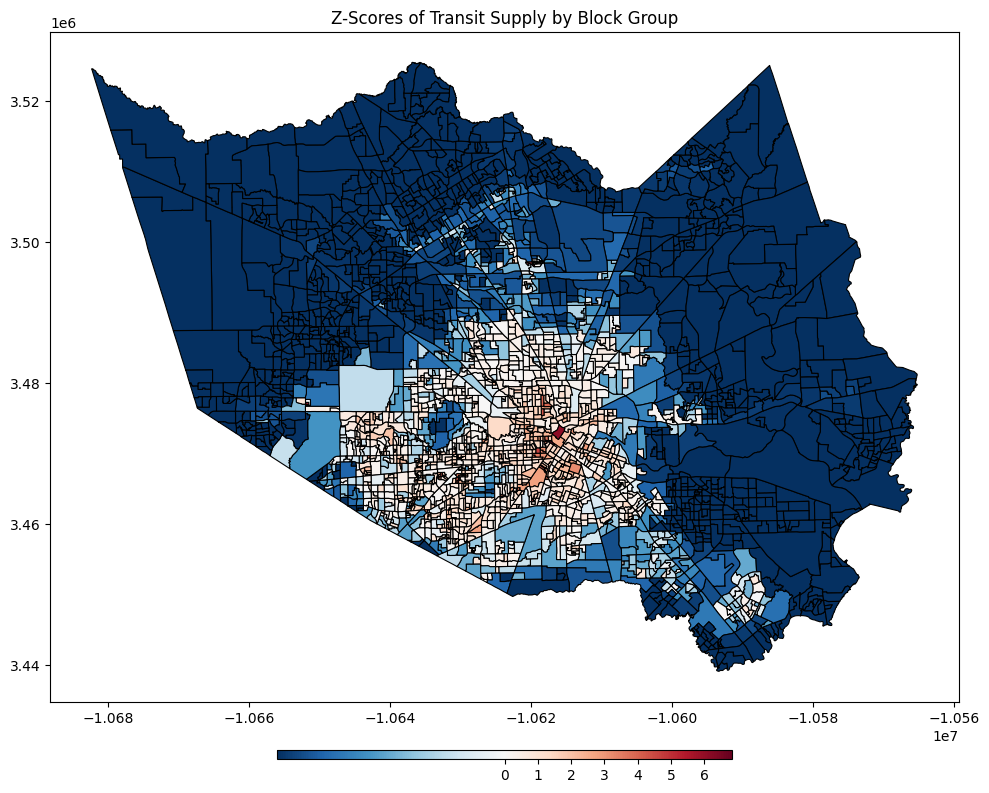

GEOID20  transit_supply_z
0     482011000011          2.601958
1     482011000012          2.028910
2     482012104001          0.222564
3     482012104002          0.673399
4     482012105001          0.601547
...            ...               ...
2825  482019801001         -0.730623
2826  482019802001          0.798618
2827  482019803001          2.162471
2828  482019804001          3.222473
2829  482019807001          6.095513

[2830 rows x 2 columns]

In [87]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def calculate_transit_supply(block_group_shapes, gtfs_data_path, edges, nodes, show_visual = True):
    """
    Calculate transit supply based on GTFS data, focusing on stop density and route density.
    """
    # Reproject block groups and calculate area in acres
    block_group_shapes = block_group_shapes.to_crs(epsg=3857)
    block_group_shapes['acres'] = block_group_shapes.geometry.area * 0.000247105

    # Check for zero or NaN values in acres
    if (block_group_shapes['acres'] == 0).any():
        print("Warning: Some block groups have zero area, which may cause division issues.")
    if block_group_shapes['acres'].isna().any():
        print("Warning: Some block groups have NaN areas. These rows may need to be handled or excluded.")
    # calculate z-scores
    route_density_z = calculate_route_density(gtfs_data_path, block_group_shapes, show_visual=True)
    stops_density_z = calculate_stops_density(block_group_shapes, show_visual=True)
    freq_density_z = calculate_avg_weekday_service_per_block_group(gtfs_data_path, block_group_shapes, show_visual=True)
    #edges, nodes = load_street_network("Houston, Texas, USA", crs_epsg=3857)
    osm_density_zs  = calculate_transit_features_per_block_group(block_group_shapes, edges, nodes, show_visual=True)
    # Ensure each result is a DataFrame with 'GEOID20' as the index or a column
    # Set 'GEOID20' as the index to ensure consistency for merging if not already done
    route_density_z = route_density_z.set_index('GEOID20')
    stops_density_z = stops_density_z.set_index('GEOID20')
    freq_density_z = freq_density_z.set_index('GEOID20')
    osm_density_zs = osm_density_zs.set_index('GEOID20')

    # Merge all results into one GeoDataFrame by 'GEOID20'
    combined_density_zs = stops_density_z.merge(route_density_z, on='GEOID20', how='left') # Using merge instead of join
    #combined_density_zs = combined_density_zs.merge(stops_density_z, on='GEOID20', how='left') # Using merge instead of join
    combined_density_zs = combined_density_zs.merge(freq_density_z, on='GEOID20', how='left') # Using merge instead of join
    combined_density_zs = combined_density_zs.merge(osm_density_zs, on='GEOID20', how='left') # Using merge instead of join


    # Fill any missing values (if necessary)
    combined_density_zs = combined_density_zs.fillna(0)  # or use another method if preferred

    # Reset index if needed to keep 'GEOID20' as a column in the final DataFrame
    combined_density_zs = combined_density_zs.reset_index()
    # Sum z-scores
    block_group_shapes['transit_supply'] = (combined_density_zs['route_density_z'] +
                                             combined_density_zs['stops_density_z'] +
                                             combined_density_zs['average_weekday_service_density_z'] +
                                             combined_density_zs['sidewalk_length_density_z'] +
                                             combined_density_zs['bike_route_length_density_z'] +
                                             combined_density_zs['low_speed_road_length_density_z'] +
                                             combined_density_zs['intersection_density_density_z'])
    # finally, take the zscore of the transit supply
    block_group_shapes['transit_supply_z'] = zscore(block_group_shapes['transit_supply'])
    print(combined_density_zs.head())
    if show_visual:
        plot_heatmap_on_bg(block_group_shapes, 'transit_supply_z', "Z-Scores of Transit Supply by Block Group")

    return block_group_shapes[[
        'GEOID20', 'transit_supply_z'
    ]]
#edges, nodes = load_street_network("Houston, Texas, USA", crs_epsg=3857)
gtfs_data_path = "/content/drive/MyDrive/capstone/data/jiao_recreation/gtfs_houston"  # Path to GTFS files
BG_shp = gpd.read_file('/content/drive/MyDrive/capstone/data/jiao_recreation/tl_2020_48201_bg20 2/tl_2020_48201_bg20.shp')
supply_df = calculate_transit_supply(BG_shp, gtfs_data_path, edges, nodes)

<ipython-input-101-b5522407b741>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supply_df["GEOID_BG"] = supply_df["GEOID20"]
<ipython-input-101-b5522407b741>:48: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  transit_gap_gdf.plot(column='gap_category', categorical=True, legend=True,


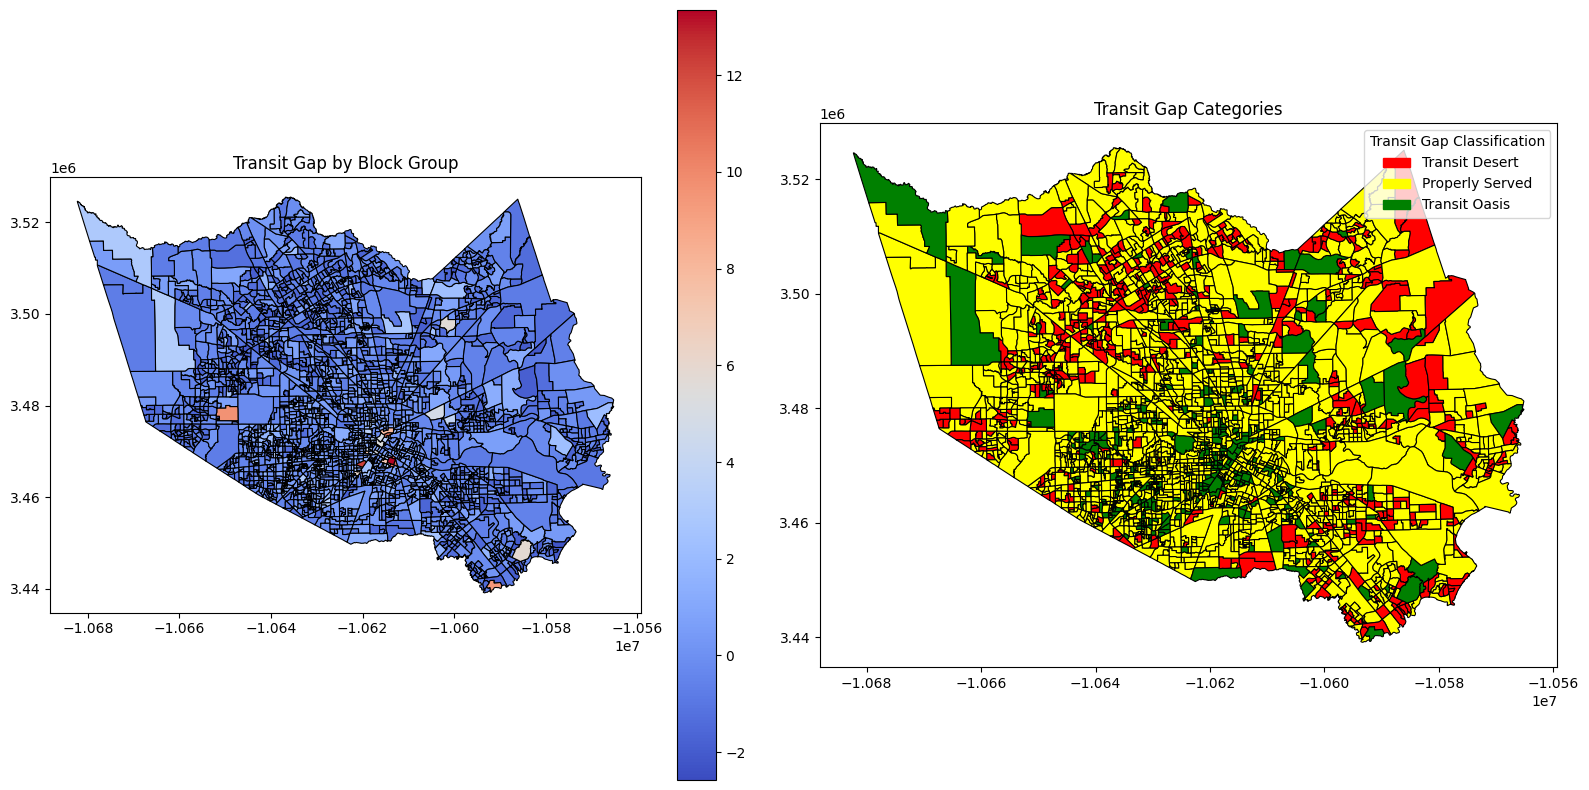

        GEOID20  transit_supply_z      GEOID_BG  trans_dep_per_z  \
0  482011000011          2.601958  482011000011        -2.735739   
1  482011000012          2.028910  482011000012        -1.088016   
2  482012104001          0.222564  482012104001        -0.152612   
3  482012104002          0.673399  482012104002        -0.563176   
4  482012105001          0.601547  482012105001         0.177873   

                                            geometry  transit_gap  \
0  POLYGON ((-10617052.129 3472431.021, -10617048...     5.337698   
1  POLYGON ((-10615745.461 3472471.029, -10615679...     3.116926   
2  POLYGON ((-10616753.793 3476682.632, -10616745...     0.375176   
3  POLYGON ((-10616104.355 3476145.957, -10616093...     1.236575   
4  POLYGON ((-10616310.185 3477634.824, -10616309...     0.423674   

      gap_category  
0    Transit Oasis  
1    Transit Oasis  
2  Properly Served  
3    Transit Oasis  
4  Properly Served  


In [101]:


def calculate_transit_gap(supply_df, demand_df, show_visual=True):
    """
    Calculate the transit gap by merging transit supply and demand data on BG_GEOID,
    with a final standardization of the supply z-scores.

    Parameters:
    - supply_df: DataFrame containing transit supply data with columns ['BG_GEOID', 'transit_supply']
    - demand_df: DataFrame containing transit demand data with columns ['BG_GEOID', 'trans_dep_pop_z']
    - show_visual: Boolean indicating whether to show a heatmap visualization of the transit gap.

    Returns:
    - GeoDataFrame with transit gap for each block group.
    """
    # Merge supply and demand on BG_GEOID
    supply_df["GEOID_BG"] = supply_df["GEOID20"]
    transit_gap = supply_df.merge(demand_df, on="GEOID_BG", how="inner")

    # Calculate the transit gap by subtracting demand from standardized supply
    transit_gap["transit_gap"] = transit_gap['transit_supply_z'] - transit_gap['trans_dep_per_z']

    # Categorize transit gap for visualization
    transit_gap['gap_category'] = np.where(
        transit_gap['transit_gap'] < -1, 'Transit Desert',
        np.where(transit_gap['transit_gap'] > 1, 'Transit Oasis', 'Properly Served')
    )

    # Convert to GeoDataFrame
    transit_gap_gdf = gpd.GeoDataFrame(transit_gap, geometry='geometry', crs=demand_df.crs)

    # Visualization

    def visualize_transit_gap(transit_gap_gdf, show_visual=True):
        if show_visual:
            fig, axs = plt.subplots(1, 2, figsize=(16, 8))

            # Heatmap of transit gap
            transit_gap_gdf.plot(column='transit_gap', cmap='coolwarm', legend=True, ax=axs[0],
                                linewidth=0.8, edgecolor='black')
            axs[0].set_title("Transit Gap by Block Group")

            # Define categories and color map
            color_map = {'Transit Desert': 'red', 'Properly Served': 'yellow', 'Transit Oasis': 'green'}
            transit_gap_gdf['gap_category'] = transit_gap_gdf['transit_gap'].apply(
                lambda x: 'Transit Desert' if x < -1 else 'Transit Oasis' if x > 1 else 'Properly Served'
            )

            # Categorical map for transit gap classification
            transit_gap_gdf.plot(column='gap_category', categorical=True, legend=True,
                                color=transit_gap_gdf['gap_category'].map(color_map), ax=axs[1],
                                linewidth=0.8, edgecolor='black')
            axs[1].set_title("Transit Gap Categories")

            # Add a custom legend for the categorical map
            import matplotlib.patches as mpatches
            legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]
            axs[1].legend(handles=legend_patches, title="Transit Gap Classification", loc='upper right')

            plt.tight_layout()
            plt.show()
    visualize_transit_gap(transit_gap_gdf)
    return transit_gap_gdf
# Usage example
result_df = calculate_transit_gap(supply_df, transit_need, show_visual=True)
print(result_df.head())